In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def gt(time0):
    return str(f'{np.round(time.time() - time0,3)} s')


def u(low=0.0, high=1.0):
    #np.random.seed(11)
    return np.random.uniform(low=low, high=high)


def pm():
    if u() > 0.5:
        return 1
    else:
        return -1


def plot_circle(ax1, r, x_c, x):
    ''' Plot circle with chosen point '''
    # Number of values for circle edge
    n_val = 250
    # Generate evenly distributed values around circle
    values = np.arange(0, n_val+1)/n_val
    theta_plt = 2*np.pi*values
    # Get x and y values of circle edge
    # !! x_c = [-x_c_y, x_c_x]
    [x_plt, y_plt] = [r*np.cos(theta_plt)+x_c[1], r*np.sin(theta_plt)-x_c[0]]
    # Plot circle
    ax1.fill(x_plt, y_plt, color='w', zorder=-1)
    # Plot point [-y, x]
    ax1.scatter(x[1], -x[0], color='r')
    ax1.set_facecolor('k')
    # Print radius 
    ax1.text(0.05, 0.05, f'r = {np.round(r,3)}', transform=ax1.transAxes, color='w')
    # Make axis equally long
    ax1.set_xlim([-0.5, 0.5])
    ax1.set_ylim([-0.5, 0.5])
    ax1.set_aspect('equal')


def plot_ellipse(ax1, r, e, x, x_c, rot, curvature):
    # Number of values for circle edge
    n_val = 250
    # Generate evenly distributed values around circle
    values = np.arange(0, n_val+1)/n_val
    theta_plt = 2*np.pi*values
    # Get x and y values of circle edge
    [x_plt, y_plt] = [r/e*np.cos(theta_plt), r*np.sin(theta_plt)]
    x_plt_tmp = x_plt.copy()
    y_plt_tmp = y_plt.copy()
    x_plt = x_plt_tmp*np.cos(-rot) - y_plt_tmp*np.sin(-rot)
    y_plt = x_plt_tmp*np.sin(-rot) + y_plt_tmp*np.cos(-rot)
    x_plt = x_plt + x_c[1]
    y_plt = y_plt - x_c[0]
    # Plot circle
    ax1.fill(x_plt, y_plt, color='w', zorder=-1)
    # Plot point [-y, x]
    ax1.scatter(x[1], -x[0], color='r')
    ax1.set_facecolor('k')
    # Print radius 
    ax1.text(0.5, 0.5, f'r = {np.round(r,3)}\nk = {np.round(curvature,3)}', transform=ax1.transAxes, color='k', ha='center')
    # Make axis equally long
    # ax1.set_xlim([-0.5, 0.5])
    # ax1.set_ylim([-0.5, 0.5])
    ax1.set_aspect('equal')



def plot_vof(ax2, vof_df, vof_array, st_sz, Delta_vof):
    ''' Plot stencil with geometry and vof values '''
    # print(f'vof_df:\n{vof_df}')
    # Initialize image array
    image = np.array([])
    for column in range(st_sz[0]):  # y
        # Initialize row array
        column_values = np.array([])
        # Glue arrays in vof_df together
        for row in range(st_sz[1]):  # x
            if len(column_values) == 0:
                # row_values = vof_df[row*st_sz[1]+column]
                # row_values = vof_df.iloc[row, column]
                column_values = vof_df.iloc[row, column]
            else:
                # row_values = np.concatenate((row_values, vof_df[row*st_sz[1]+column]), axis=1)
                # row_values = np.concatenate((row_values, vof_df.iloc[row, column]), axis=1)
                column_values = np.concatenate((column_values, vof_df.iloc[row, column]), axis=1)
        # Glue rows together
        if len(image) == 0:
            image = column_values
        else:
            image = np.concatenate((image, column_values), axis=0)
    # Get image dimensions to calculate grid
    imgdim = np.array([st_sz[0], st_sz[1]])*1/Delta_vof
    # Set ticks
    x_ticks = np.arange(0, imgdim[1]+1, int(1/Delta_vof))
    y_ticks = np.arange(0, imgdim[0]+1, int(1/Delta_vof))
    ax2.set_xticks(x_ticks)
    ax2.set_yticks(y_ticks)
    # Set grid
    ax2.grid(which='both')
    # Generate vof labels
    vs = vof_array.shape
    for row in range(vs[0]):
        for column in range(vs[1]):
            # Calculate position of text
            txt_pt = [column*1/Delta_vof+(1/Delta_vof)/10, row*1/Delta_vof+(1/Delta_vof)/10]
            # Write vof value at that position
            ax2.text(txt_pt[0], txt_pt[1],
                 np.round(vof_array[column, row], 3),
                 horizontalalignment='left',
                 verticalalignment='top',
                 color='k',
                 backgroundcolor='w')
    # Show geometry
    ax2.imshow(image, cmap='Greys_r')



In [3]:
# DATA GENERATION
import itertools
import time
import pandas as pd
from progressbar import *
import matplotlib.pyplot as plt
import os
import sys

def axismatrix(n_grid, axis):
    # Generate matrix where values increase along the given axis starting at 0
    n_grid = int(n_grid)
    # Ascending values in z-direction
    return_matrix = np.tile(np.array(range(n_grid))/n_grid, (n_grid, 1))
    if axis == 0:
        return return_matrix.transpose((1, 0))
    elif axis == 1:
        return return_matrix


def cross(mid_pt, max_pt):
    # Generate cross values mid_pt - max_pt to mid_pt + max_pt in both axis
    # Generate points in direction of both axis
    points_x = np.array([np.array([mid_pt[0]]), mid_pt[1]+max_pt[1]])
    points_y = np.array([mid_pt[0]+max_pt[0], np.array([mid_pt[1]])])
    cr_x = np.array(list(itertools.product(*points_x)))
    cr_y = np.array(list(itertools.product(*points_y)))
    # Get list of all unique cross points
    return np.unique(np.concatenate((cr_x, cr_y), axis=0), axis=0)


def generate_data(N_values, st_sz, equal_kappa, neg, silent=False, ellipse=False):

    time0 = time.time()
    debug = True

    # ↓↓ Parameters ↓↓ #
    # Script
    N_values = int(N_values)           # Number of values
    visualize = True if (N_values == 1) else False
    # visualize = False
    # Grid
    Delta = 1/1000                     # Gridsize
    Delta_vof = 1/32                   # VoF Gridsize 0.1% accuracy: 32 -> ~1000 (1024) points
    L = 1                              # Length of space
    X_c = np.array([L/2, L/2])         # Midpoint of geometry
    # Geometry
    # R_min = max(st_sz)/2*Delta       # Minimal radius (so the circle is not smaller than the stencil)
    R_min = 7/2*Delta
    R_max = 0.5                        # Maximal radius
    kappa_min = L*Delta*2/R_max
    kappa_max = L*Delta*2/R_min
    # kappa_min = 0.49
    # kappa_max = 0.52
    equal_kappa = equal_kappa          # Equal kappa or equal radius
    e_min = 1                          # Minimal side ratio of ellipse (1 = circle)
    e_maxmin = 1.5                     # Minimal maximal side ratio (for kappa=kappa_max)
    e_maxmax = 5                      # Maximal maximal side ratio (for kappa=kappa_min)
    # Stencil
    st_sz = st_sz                      # Stencil size [y, x]
    print(f'st_sz:\n{st_sz}')
    cr_sz = [3, 3]                     # Cross size (for gradient calculation)
    # ↑↑ Parameters ↑↑ #
    
    # Calculate midpoints
    st_mid = [int((st_sz[0]-1)/2), int((st_sz[1]-1)/2)]
    cr_mid = [int((cr_sz[0]-1)/2), int((cr_sz[1]-1)/2)]
    # Generate cross points relative to cell
    st_crp = np.array([np.arange(-cr_mid[0], (cr_mid[0]+1)),
                       np.arange(-cr_mid[1], (cr_mid[1]+1))])
    # Generate stencil points relative to cell
    st_stp = np.array([np.arange(-st_mid[0], (st_mid[0]+1)),
                       np.arange(-st_mid[1], (st_mid[1]+1))])*Delta
    # Generate a local grid for later usage (y from top to bottom, x from left to right)
    local_grid = np.array([axismatrix(1/Delta_vof, 0),
                           axismatrix(1/Delta_vof, 1)])*Delta
    # Initialize output list
    output_list = []
    # Initialize progress bar
    widgets = ['Data generation: ', Percentage(), ' ', Bar(marker='=',left='[',right=']'),
           ' ', ETA()] #see docs for other options
    if not silent:
        pbar = ProgressBar(widgets=widgets, maxval=N_values)
        pbar.start()
    for n in range(N_values):
        if not silent:
            pbar.update(n)
        if equal_kappa:
            if ellipse:
                # Get random curvature
                curvature = -(kappa_min + u()*(kappa_max - kappa_min))
                # Get random side ratio
                e_max = e_maxmax + (curvature/(-kappa_max))**0.5*(e_maxmin - e_maxmax)
                # e_max = 2
                e = e_min+u()*(e_max-e_min)
                # Calculate ellipse radius
                # r = L*Delta/(-curvature*e) + u()**4*((e**2*L*Delta)/(-curvature) - L*Delta/(-curvature*e))
                # r = -L*Delta*2/curvature*e**(-1 + 3*u()**1.5)
                r = -L*Delta*2/curvature*e**(-1 +(curvature/(-kappa_max)) + (3-(curvature/(-kappa_max)))*u()**1.5)
                if visualize:
                    print(f'\nkappa_max:\n{-kappa_max}')
                    print(f'curvature/kappa_max:\n{(curvature/-kappa_max)}')
                    print(f'e_max:\n{e_max}')
                    print(f'kappa:\t{curvature}\ne:\t{e}\nr:\t{r}')
            else:
                # Get random curvature
                curvature = -(kappa_min + u()*(kappa_max - kappa_min))
                # Calculate radius
                r = -L*Delta*2/curvature
        else:
            # Get random radius
            r = R_min + u()*(R_max - R_min)
            # Calculate curvature
            curvature = -L*Delta*2/r  # Stimmt das auch, wenn der Stencil anders gewählt wird?
        # Move midpoint by random amount inside one cell
        x_c = np.array([u(), u()])*Delta
        # x_c = np.array([0, 0])

        # Get point on geometry
        if ellipse:
            # Get x and y coordinates of point on ellipse with the given curvature 
            # (and flip x and y coordinates randomly with pm)
            pt_x = pm()*np.sqrt((((-e**2*r**2*L*Delta*2)/curvature)**(2/3)-r**2)/(e**4-e**2))
            pt_y = pm()*np.sqrt(r**2-e**2*(pt_x)**2)
            # print(f'pt_x:\n{pt_x}')
            
            # Rotate with random angle
            rot = u()*2*np.pi
            rot_matrix = [[np.cos(rot), -np.sin(rot)],
                          [np.sin(rot), np.cos(rot)]]
            [pt_x, pt_y] = np.matmul(rot_matrix, [pt_x, pt_y])
            
            # Make x array and add random shift of origin x_c
            x = np.array([pt_y, pt_x])
            x = x+x_c
        else:
            # Get random spherical angle
            theta = 2*np.pi*u()
            # Get cartesian coordinates on sphere surface
            x_rel = np.array([r*np.sin(theta),   # y
                              r*np.cos(theta)])  # x
            x = np.array([x_c[0]+x_rel[0],
                          x_c[1]+x_rel[1]])

        # Round point to get origin of local coordinates in global coordinates relative to geometry origin
        round_point = np.floor(x*1/Delta*L)*Delta/L
            
        # > Evaluate VOF values on cross around origin first to calculate the gradient
        if st_sz[0] != st_sz[1]:
            # Create nan array for stencil values
            vof_array = np.empty((cr_sz[0], cr_sz[1]))
            vof_array[:] = np.nan
            if visualize:
                # Create dict to fetch shape of geometry in local coordinates
                vof_df = pd.DataFrame(index=range(cr_sz[0]), columns=range(cr_sz[1]))
            # Generate cross points in x and y direction
            cross_point_origins = cross(round_point, st_crp*Delta)
            cross_point_indices = cross(cr_mid, st_crp)
            for idx, ill in enumerate(cross_point_indices):
                # Get origin coordinates too
                lo = cross_point_origins[idx]
                # Values of local grid relative to geometry origin
                [y_l, x_l] = np.array([local_grid[0] + lo[0] - x_c[0],
                                       local_grid[1] + lo[1] - x_c[1]])
                if ellipse:
                    # Rotate geometry back to calculate ellipse
                    x_ltmp = x_l.copy()
                    y_ltmp = y_l.copy()
                    x_l = x_ltmp*np.cos(rot)+y_ltmp*np.sin(rot)
                    y_l = -x_ltmp*np.sin(rot)+y_ltmp*np.cos(rot)

                    # Get radii on local grid (np.multiply way faster than np.power) r^2 = e^2*x^2 + y^2
                    r_sqr = e**2*np.multiply(x_l, x_l) + np.multiply(y_l, y_l)
                else:
                    # Get radii on local grid (np.multiply way faster than np.power) r^2 = x^2 + y^2 + z^2
                    r_sqr = np.multiply(x_l, x_l) + np.multiply(y_l, y_l)
                # Calculate 1s and 0s on local grid 
                r_area = np.where(r_sqr <= r*r, 1, 0)
                # Get VOF values by integration over local grid
                vof = np.sum(r_area)/r_area.size
                '''
                AB HIER SIND X UND Y NOCH VERTAUSCHT (GANZE GRADIENTENBILDUNG)
                '''
                # Write vof value into stencil value array
                vof_array[ill[1], ill[0]] = vof  # g
                if visualize:
                    # Save the r_area array for plotting
                    vof_df.iloc[ill[1], ill[0]] = r_area  # g
            print(f'vof_array:\n{vof_array}')
            # Calculate gradient with central finite difference:
            grad_y = vof_array[cr_mid[0]+1, cr_mid[1]]-vof_array[cr_mid[0]-1, cr_mid[1]]
            grad_x = vof_array[cr_mid[0], cr_mid[1]+1]-vof_array[cr_mid[0], cr_mid[1]-1]
            print(f'grad_y:\n{grad_y}')
            print(f'grad_x:\n{grad_x}')
            normal = -1/np.sqrt(grad_y*grad_y + grad_x*grad_x)*np.array([grad_y, grad_x])
            if np.abs(normal[0]) > np.abs(normal[1]): # if gradient points more to y-direction
                # Set direction to 0 (y)
                direction = 0
                # Leave stencil as it is
                st_stp_loc = st_stp
                st_sz_loc = st_sz
                st_mid_loc = st_mid
                if visualize:
                    # Pad index
                    vof_df.index = vof_df.index+(st_sz_loc[0]-cr_sz[0])/2
                    vof_df = vof_df.reindex(range(st_sz_loc[0]))  # evtl hier noch tauschen
            else:
                # Set direction to 1 (x)
                direction = 1
                # Rotate stencil by 90 degrees (flip x and y dimensions)
                st_stp_loc = np.flip(st_stp)
                st_sz_loc = np.flip(st_sz)
                st_mid_loc = np.flip(st_mid)
                if visualize:
                    # Pad columns
                    print(f'st_sz_loc[0]:\n{st_sz_loc[0]}')
                    vof_df.columns = vof_df.columns+(st_sz_loc[0]-cr_sz[0])/2
                    vof_df = vof_df.reindex(range(st_sz_loc[0]), axis='columns').astype(object)
            # Padding of vof_array so it fits the stencil
            pad_x = int((st_sz_loc[1] - vof_array.shape[1])*1/2)  # g
            pad_y = int((st_sz_loc[0] - vof_array.shape[0])*1/2)  # g
            vof_array = np.pad(vof_array,
                               [[pad_y, pad_y], [pad_x, pad_x]],  # g
                               mode='constant', constant_values=np.nan)  # g
            if visualize:
                print(f'normal:\n{normal}')
        else:
            # If gradient is not calculated, initialize vof_array and vof_df with stencil size
            # Create nan array for stencil values
            vof_array = np.empty((st_sz[0], st_sz[1]))
            vof_array[:] = np.nan
            if visualize:
                # Create dict to fetch shape of geometry in local coordinates
                vof_df = pd.DataFrame(index=range(st_sz[0]), columns=range(st_sz[1]))
            # Leave stencil as it is
            st_stp_loc = st_stp
            st_sz_loc = st_sz
            st_mid_loc = st_mid

        print(f'st_sz_loc:\n{st_sz_loc}')
        print(f'vof_array:\n{vof_array}')
        print(f'vof_df:\n{vof_df.to_string()}')

        if visualize:
	    # Initialize plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=150)
            if ellipse:
                # Plot ellipse
                plot_ellipse(ax1, r, e, x, x_c, rot, curvature)
            else:
                # Plot circle
                plot_circle(ax1, r, x_c, x)

        # Get origins of local coordinates of stencil points
        local_origin_points = np.array([round_point[0]+st_stp_loc[0],
                                        round_point[1]+st_stp_loc[1]])
        # Get list of all origins in stencil
        local_origins = np.array(list(itertools.product(*local_origin_points)))
        # Get list of all stencil indices combinations
        local_indices = np.array(list(itertools.product(range(st_sz_loc[1]),range(st_sz_loc[0]))))  # g

        # Iterate over all stencil indices combinations
        for idx, ill in enumerate(local_indices):
            # Skip values that were already calculated for the gradient
            if np.isnan(vof_array[ill[1], ill[0]]):
                # Get origin coordinates too
                lo = local_origins[idx]
                # Values of local grid relative to geometry origin
                [y_l, x_l] = np.array([local_grid[0] + lo[0] - x_c[0],
                                       local_grid[1] + lo[1] - x_c[1]])
                if ellipse:
                    # Rotate geometry back to calculate ellipse
                    x_ltmp = x_l.copy()
                    y_ltmp = y_l.copy()
                    x_l = x_ltmp*np.cos(rot)+y_ltmp*np.sin(rot)
                    y_l = -x_ltmp*np.sin(rot)+y_ltmp*np.cos(rot)

                    # Get radii on local grid (np.multiply way faster than np.power) r^2 = e^2*x^2 + y^2
                    r_sqr = e**2*np.multiply(x_l, x_l) + np.multiply(y_l, y_l)
                else:
                    # Get radii on local grid (np.multiply way faster than np.power) r^2 = x^2 + y^2 + z^2
                    r_sqr = np.multiply(x_l, x_l) + np.multiply(y_l, y_l)
                # Calculate 1s and 0s on local grid 
                r_area = np.where(r_sqr <= r*r, 1, 0)
                # Get VOF values by integration over local grid
                vof = np.sum(r_area)/r_area.size
                # Write vof value into stencil value array
                vof_array[ill[1], ill[0]] = vof
                if visualize:
                    # Save the r_area array for plotting
                    vof_df.iloc[ill[1], ill[0]] = r_area
        print(f'vof_array:\n{vof_array}')
        if visualize:
            # Plot vof
            plot_vof(ax2, vof_df, vof_array, st_sz_loc, Delta_vof)
            # Show plot
            fig.tight_layout() 
            plt.show()
        # Only proceed if data is valid (invalid = middle point of stencil does not contain interface)
        if (vof_array[st_mid_loc[0], st_mid_loc[1]] > 0) & (vof_array[st_mid_loc[0], st_mid_loc[1]] < 1):
            if neg:
                # Invert values by 50% chance
                if u() > 0.5:
                    curvature = -curvature
                    vof_array = 1-vof_array
            # Reshape vof_array
            output_array = np.reshape(vof_array, (1, np.prod(st_sz_loc)))[0].tolist()
            # Insert curvature value at first position
            output_array.insert(0, curvature)
            if debug:
                # DEBUGGING: Insert r, e, pt_x, pt_y
                output_array.insert(0, r)
                output_array.insert(0, e)
                output_array.insert(0, pt_y)
                output_array.insert(0, pt_x)
            # Append list to output list
            output_list.append(output_array)
    if not silent:
        pbar.finish()
    if not visualize:
        # Convert output list to pandas dataframe
        output_df = pd.DataFrame(output_list)
        # Reformat column names as string and rename curvature column
        output_df.columns = output_df.columns.astype(str)
        if debug:
            output_df = output_df.rename(columns={'0':'pt_x', '1': 'pt_y', '2': 'e', '3': 'r', '4': 'curvature'})
        else:
            output_df = output_df.rename(columns={'0':'Curvature'})
        # Write output dataframe to feather file
        parent_path = os.path.dirname(os.path.abspath(sys.argv[0]))
        print(f'parent_path:\n{parent_path}')
        file_name = os.path.join(parent_path, 'data', 'datasets', 'data_'+str(st_sz[0])+'x'+str(st_sz[1])+('_eqk' if equal_kappa else '_eqr')+('_neg' if neg else '_pos')+('_ell' if ellipse else '_cir')+'.feather')
        # file_name = os.path.join(parent_path, 'data', 'datasets', 'data_'+str(st_sz[0])+'x'+str(st_sz[1])+('_eqk' if equal_kappa else '_eqr')+('_neg' if neg else '_pos')+('_ell' if ellipse else '_cir')+'_flat_e'+'.feather')
        output_df.reset_index(drop=True).to_feather(file_name)
        # Print string with a summary
        geometry = ('Ellipse' if ellipse else 'Circle')
        print(f'Generated {output_df.shape[0]} tuples in {gt(time0)} with:\nGeometry:\t{geometry}\nGrid:\t\t{int(1/Delta)}x{int(1/Delta)}\nStencil size:\t{st_sz}\nVOF Grid:\t{int(1/Delta_vof)}x{int(1/Delta_vof)}\nVOF Accuracy:\t{np.round(100*Delta_vof**2,3)}%\nNeg. Values:\t{neg}')

Data generation: N/A% [                                        ] ETA:  --:--:--

st_sz:
[5, 5]

kappa_max:
-0.5714285714285714
curvature/kappa_max:
0.1860078010546318
e_max:
3.49049824017352
kappa:	-0.10629017203121817
e:	1.4489613429042216
r:	0.015070457873002634
st_sz_loc:
[5, 5]
vof_array:
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
vof_df:
     0    1    2    3    4
0  NaN  NaN  NaN  NaN  NaN
1  NaN  NaN  NaN  NaN  NaN
2  NaN  NaN  NaN  NaN  NaN
3  NaN  NaN  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN
vof_array:
[[0.         0.         0.         0.56152344 1.        ]
 [0.         0.         0.         0.79492188 1.        ]
 [0.         0.         0.0078125  0.96679688 1.        ]
 [0.         0.         0.10058594 1.         1.        ]
 [0.         0.         0.17285156 1.         1.        ]]


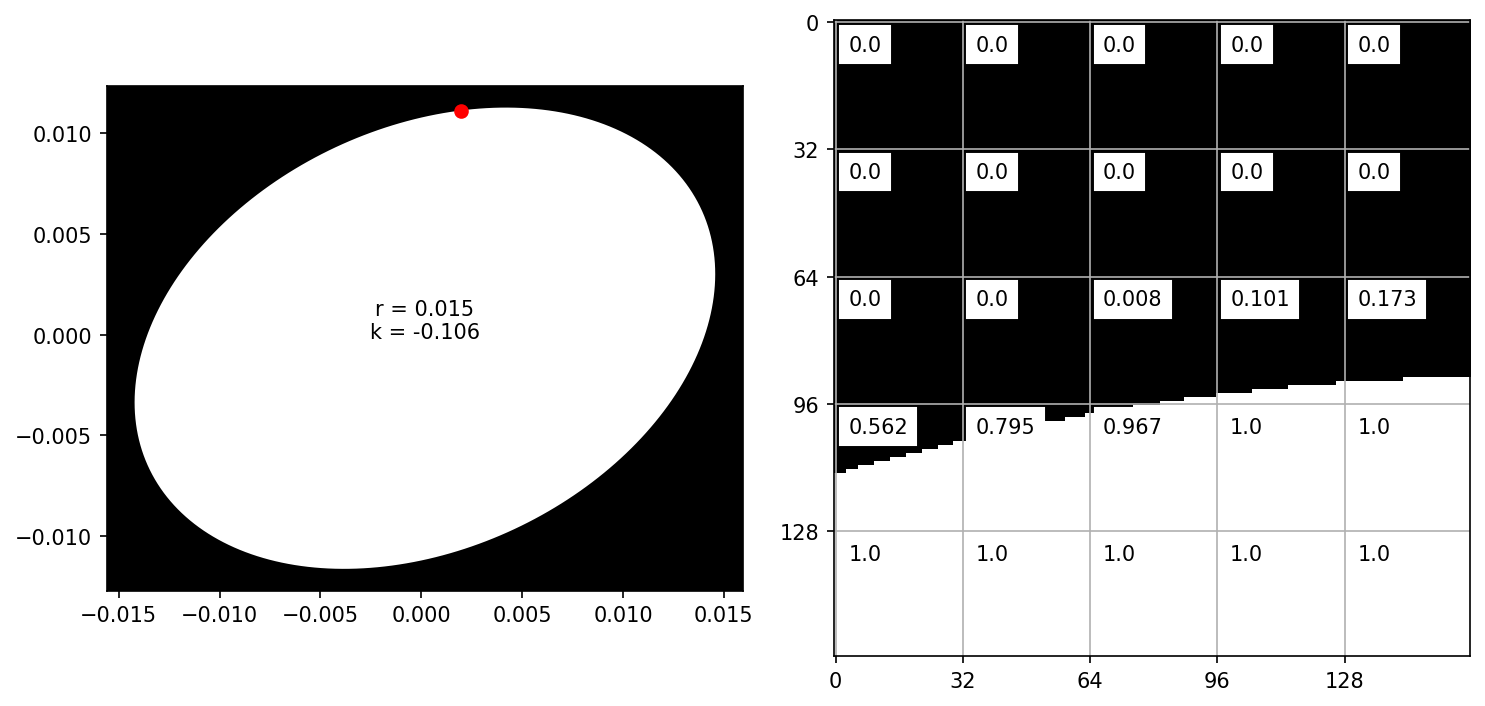

Data generation: 100% [========================================] Time:  0:00:00


In [5]:
generate_data(N_values=1, st_sz=[5, 5], equal_kappa=True, neg=True, silent=False, ellipse=True)
